In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import concatenate, Conv2D, Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Cropping2D
from keras.optimizers import Adam, Adamax, Nadam, Adadelta, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras.utils.io_utils import HDF5Matrix
import h5py
import keras

from keras.layers.normalization import BatchNormalization
from sklearn.metrics import jaccard_similarity_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2
import shapely.wkt
import shapely.affinity
from shapely.geometry import MultiPolygon, Polygon
from collections import defaultdict
from shapely.wkt import loads as wkt_loads
from keras.backend import binary_crossentropy
import tensorflow as tf
import tifffile as tiff


/home/yokoyang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# Dir = '/home/yokoyang/PycharmProjects/untitled/v-shanghai'
Dir = '/home/yokoyang/PycharmProjects/untitled/v-shanghai'
train_img = pd.read_csv(Dir + '/data_imageID.csv')

Image_ID = sorted(train_img.ImageId.unique())
print(Image_ID)

N_split = 4

Patch_size = 192
crop_size = 224
edge_size = int((crop_size - Patch_size) / 2)
Class_Type = 1
# 1200 = 300 * 4
# size = 1024
Scale_Size = Patch_size * N_split
get_size = 80

['0_0', '1_2', '2_4', '3_6', '4_8', '6_1', '7_3', '8_5', '9_7']


In [3]:
def get_mask(image_id):
    filename = os.path.join(
        Dir, 'general_building', '{}.tif'.format(image_id))
    msk = tiff.imread(filename)
    msk = msk.astype(np.float32) / 255
    msk = cv2.resize(msk, (Scale_Size, Scale_Size))
    msk_img = np.zeros([Scale_Size, Scale_Size], dtype=np.uint8)
    msk_img[:, :] = msk[:, :, 1]
    msk_img ^= 1
    return msk_img


def get_image(image_id):
    filename = os.path.join(
        Dir, 'split-data', '{}.tif'.format(image_id))
    img = tiff.imread(filename)
    img = img.astype(np.float32) / 255
    img_RGB = cv2.resize(img, (Scale_Size, Scale_Size))
    return img_RGB


def reflect_img(img):
    reflect = cv2.copyMakeBorder(img, int(edge_size), int(edge_size), int(edge_size), int(edge_size),
                                 cv2.BORDER_REFLECT)
    return reflect


def rotate_img(img, ang, size):
    rows = size
    cols = size
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), 90 * ang, 1)
    dst = cv2.warpAffine(img, M, (cols, rows))
    return dst


def rotate_msk(msk, ang):
    return np.rot90(msk, ang)


def get_patch(img_id, pos=1):
    img_ = []
    msk_ = []
    img = get_image(img_id)
    img = reflect_img(img)
    mask = get_mask(img_id)
    for i in range(N_split):
        for j in range(N_split):
            y = mask[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)]
            if ((pos == 1) and (np.sum(y) > 0)) or (pos == 0):
                x_start = int(Patch_size * i)
                x_end = int(Patch_size * (i + 1) + edge_size * 2)
                y_start = int(Patch_size * j)
                y_end = int(Patch_size * (j + 1) + edge_size * 2)
                x = img[x_start:x_end, y_start:y_end, :]
                # start rotate y and x
                rdm = random.uniform(-2, 5)
                if rdm > 1:
                    ang = rdm // 1
                    x = rotate_img(x, ang, crop_size)
                    y = rotate_msk(y, ang)
                    # print(x.shape)
                    # print(y.shape)

                img_.append(x)
                msk_.append(y[:, :, None])

    return img_, msk_


def get_all_patches(pos=1):
    img_all = []
    msk_all = []
    count = 0
    for img_id in Image_ID:
        img_, msk_ = get_patch(img_id, pos=pos)
        if len(msk_) > 0:
            count = count + 1
            if count == 1:
                img_all = img_
                msk_all = msk_
            else:
                img_all = np.concatenate((img_all, img_), axis=0)
                msk_all = np.concatenate((msk_all, msk_), axis=0)

    # if pos == 1:
    #     np.save(Dir + '/output/data_pos_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)
    #
    # else:
    #     np.save(Dir + '/output/data_%d_%d_class%d' % (crop_size, N_split, Class_Type), img_all)

    return img_all, msk_all[:, :, :, 0]


def get_normalized_patches():
    img_all, msk_all = get_all_patches()
    #     data = np.load(Dir + '/output/data_pos_%d_%d_class%d.npy' % (Patch_size, N_split, Class_Type))
    img = img_all
    msk = msk_all
    mean = np.mean(img)
    std = np.std(img)
    img = (img - mean) / std
    print(mean, std)
    print(np.mean(img), np.std(img))
    return img, msk

# In predicting testing dataset, need to use the same mean and std in preprocessing training data
def post_normalize_image(img, mean=0.338318, std=0.189734):
    img = (img - mean) / std
    return img

def save_result_pic(filename, img):
    img = img.astype(np.uint8)
    img *= 255
    cv2.imwrite(filename, img)
    
def predict_id(img_id, model, th):
    img = get_image(img_id)
    img = post_normalize_image(img)
    print(img.shape)
    prd = np.zeros((Patch_size * N_split, Patch_size * N_split, 1)).astype(np.float32)

    for i in range(N_split):
        for j in range(N_split):
            x = img[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1), :]
            x = reflect_img(x)
            tmp = model.predict(x[None, :, :, :], batch_size=4)
            prd[Patch_size * i:Patch_size * (i + 1), Patch_size * j:Patch_size * (j + 1)] = tmp
    prd_result = prd > th
    return prd_result, prd


def check_predict(model, th, img_id=Image_ID[1], Class_Type=1):
    msk_prd, row = predict_id(img_id, model, th)
    print(row.shape)
    img = get_image(img_id)
    msk_prd = msk_prd[:, :, 0]
    msk = get_mask(img_id)
    plt.figure(figsize=[21, 8])

    plt.subplot(1, 3, 1)
    plt.title('Training Image')
    plt.imshow(img)
    img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.imwrite("img_result/train"+img_id+".tif", img2)

    plt.subplot(1, 3, 2)
    plt.title('Training Mask')
    plt.imshow(msk, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk.tif", msk)
    save_result_pic("img_result/ground_truth"+img_id+".tif", msk)

    plt.subplot(1, 3, 3)
    plt.title('Predicted Mask')
    plt.imshow(msk_prd, cmap=plt.get_cmap('gist_ncar'))
    # cv2.imwrite("msk_prd.tif", msk_prd)
    print(msk_prd.max())
    plt.axis('off')
    plt.show()
    save_result_pic("img_result/msk_prd_1"+img_id+".tif", msk_prd)
    save_result_pic("img_result/msk_prd_2"+img_id+".tif", ~msk_prd)


In [4]:

smooth = 1e-12

def jaccard_coef(y_true, y_pred):
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))

    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])

    jac = (intersection + smooth) / (sum_ - intersection + smooth)

    return K.mean(jac)


def jaccard_coef_loss(y_true, y_pred):
    return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)


In [5]:
def get_unet0():
    #     Patch_size = 224
    inputs = Input((crop_size, crop_size, 3))

    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization(axis=1)(conv1)
    conv1 = keras.layers.advanced_activations.ELU()(conv1)
    conv1 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization(axis=1)(conv1)
    conv1 = keras.layers.advanced_activations.ELU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization(axis=1)(conv2)
    conv2 = keras.layers.advanced_activations.ELU()(conv2)    
    conv2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization(axis=1)(conv2)
    conv2 = keras.layers.advanced_activations.ELU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization(axis=1)(conv3)
    conv3 = keras.layers.advanced_activations.ELU()(conv3)
    conv3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization(axis=1)(conv3)
    conv3 = keras.layers.advanced_activations.ELU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization(axis=1)(conv4)
    conv4 = keras.layers.advanced_activations.ELU()(conv4)
    conv4 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization( axis=1)(conv4)
    conv4 = keras.layers.advanced_activations.ELU()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization( axis=1)(conv5)
    conv5 = keras.layers.advanced_activations.ELU()(conv5)
    conv5 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization(axis=1)(conv5)
    conv5 = keras.layers.advanced_activations.ELU()(conv5)
        
    up6 = Conv2D(256, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization(axis=1)(conv6)
    conv6 = keras.layers.advanced_activations.ELU()(conv6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization(axis=1)(conv6)
    conv6 = keras.layers.advanced_activations.ELU()(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization(axis=1)(conv7)
    conv7 = keras.layers.advanced_activations.ELU()(conv7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization(axis=1)(conv7)
    conv7 = keras.layers.advanced_activations.ELU()(conv7)
    
    up8 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization( axis=1)(conv8)
    conv8 = keras.layers.advanced_activations.ELU()(conv8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization(axis=1)(conv8)
    conv8 = keras.layers.advanced_activations.ELU()(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization(axis=1)(conv9)
    conv9 = keras.layers.advanced_activations.ELU()(conv9)    
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization(axis=1)(conv9)
    conv9 = keras.layers.advanced_activations.ELU()(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)
    cropping_2d = Cropping2D(cropping=((edge_size, edge_size), (edge_size, edge_size)),
                             input_shape=(int(crop_size), int(crop_size), 3))(conv10)

    model = Model(inputs=inputs, outputs=cropping_2d)
    model.compile(optimizer=Nadam(lr=1e-3), loss=jaccard_coef_loss, metrics=['binary_crossentropy', jaccard_coef_int])
    # model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model





(768, 768, 3)


(768, 768, 1)
True


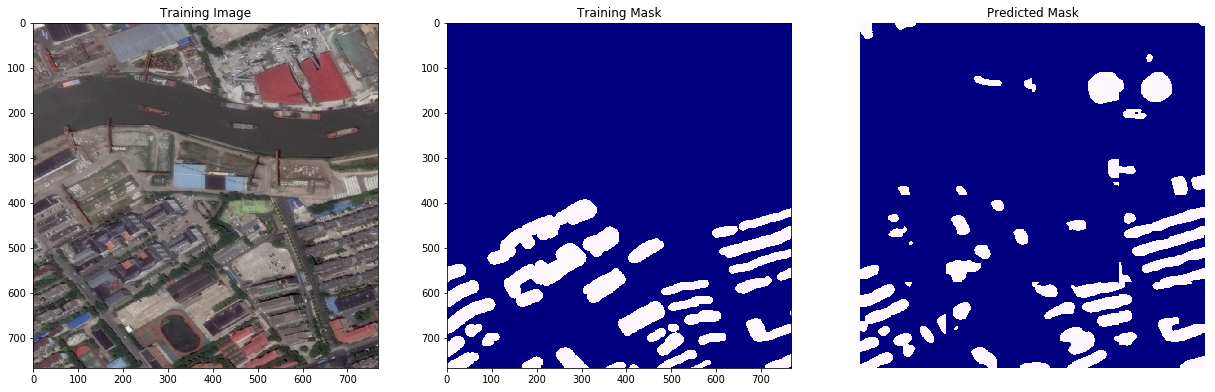

0_0
(768, 768, 3)


(768, 768, 1)
True


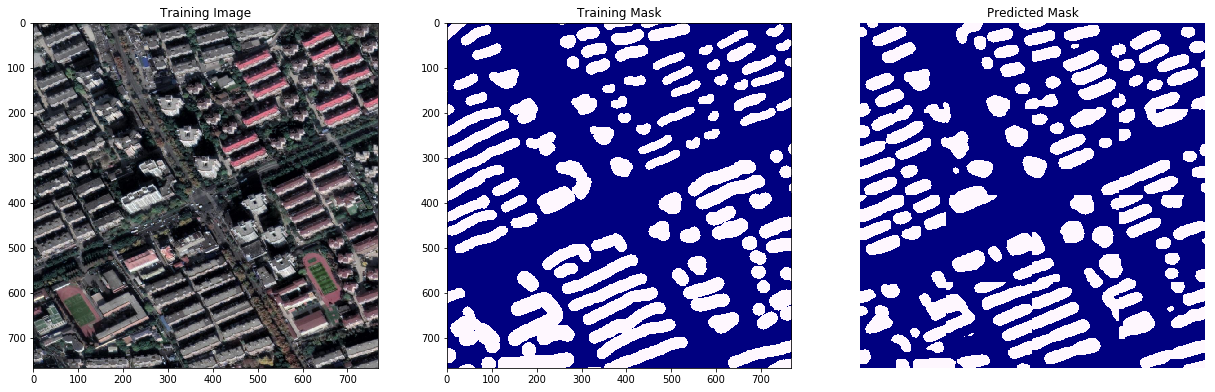

1_2
(768, 768, 3)


(768, 768, 1)
True


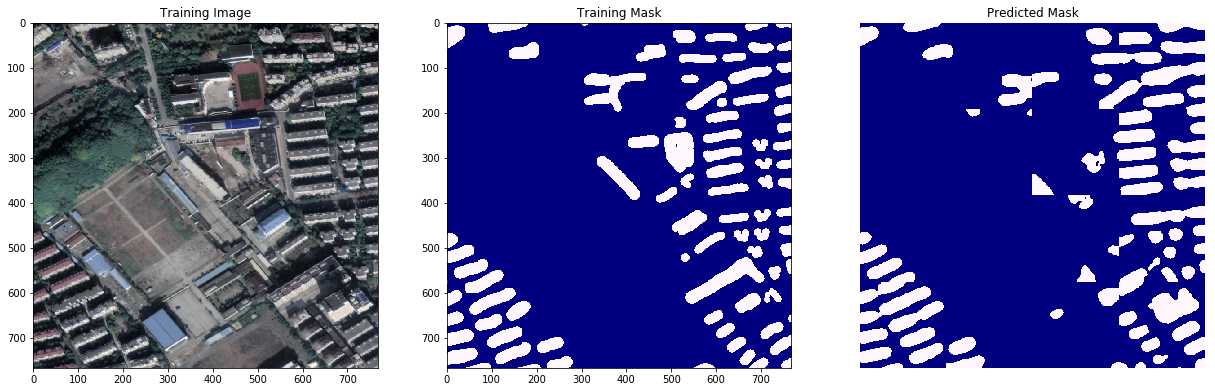

2_4
(768, 768, 3)


(768, 768, 1)


True


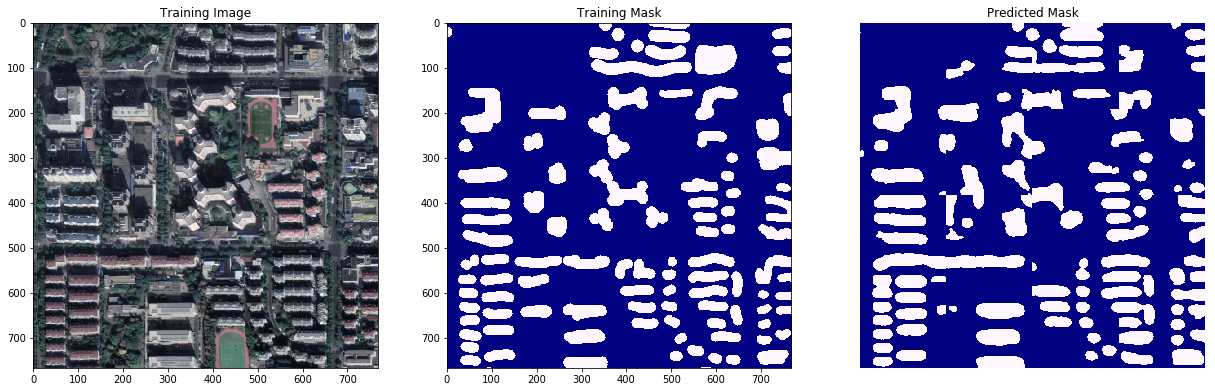

3_6
(768, 768, 3)


(768, 768, 1)
True


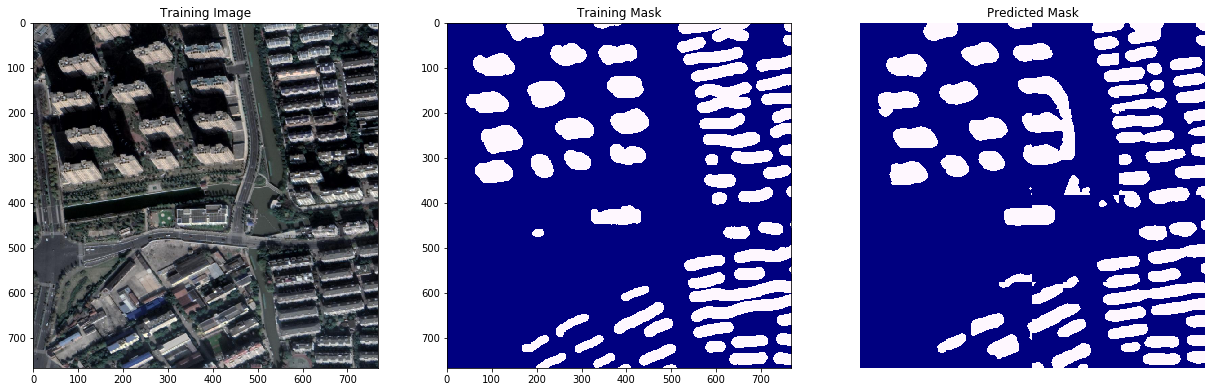

4_8
(768, 768, 3)


(768, 768, 1)
True


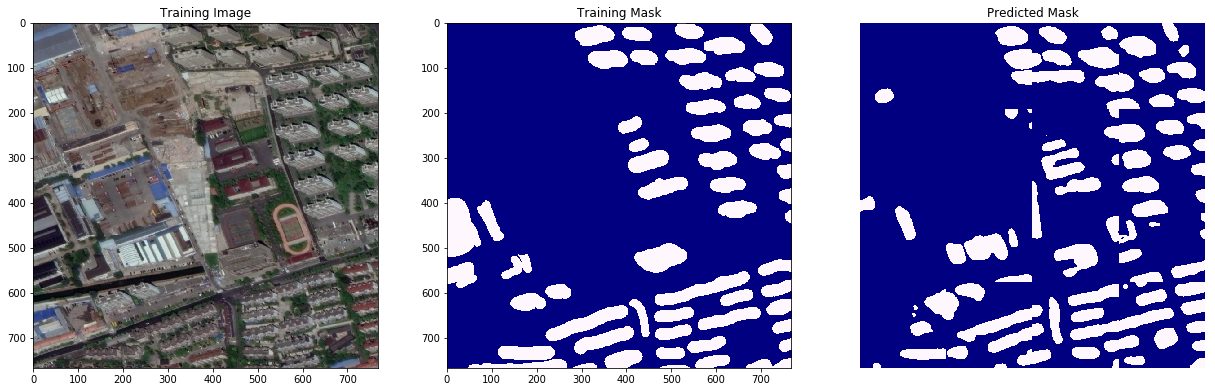

6_1
(768, 768, 3)


(768, 768, 1)
True


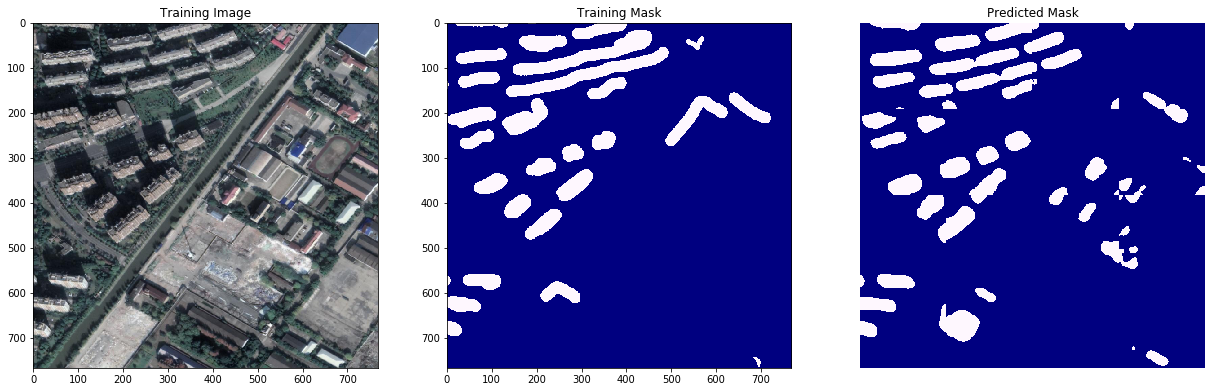

7_3
(768, 768, 3)


(768, 768, 1)
True


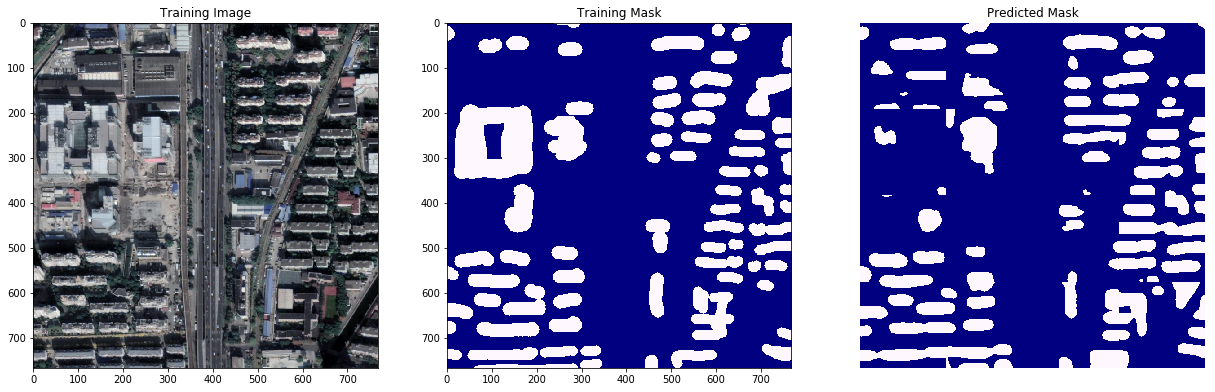

8_5
(768, 768, 3)


(768, 768, 1)
True


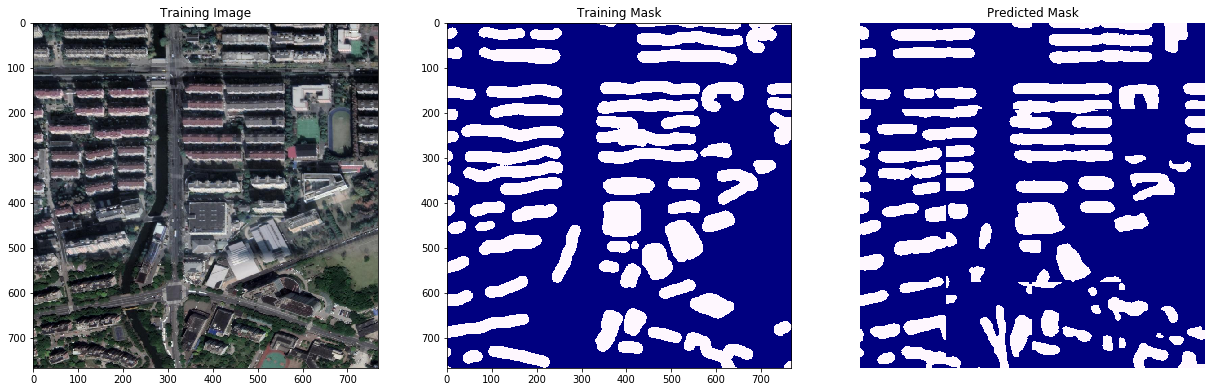

9_7


In [14]:
model = get_unet0()
model.load_weights('/home/yokoyang/PycharmProjects/untitled/me/0_rotate_val_jaccard_coef_int_building.hdf5')
for d in range(9):
    img_id = Image_ID[d]
    check_predict(model, 0.5, img_id=img_id, Class_Type=1)
    print(img_id)


In [22]:
msk = tiff.imread("/home/yokoyang/PycharmProjects/untitled/biaozhu/general_building/1_4.tif")

In [25]:
t= np.array(msk)

In [27]:
t.max()

0.0

In [19]:
msk.shape

(1024, 1024, 3)

In [24]:
msk.max()

0.0